In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pyreadstat
import pyreadstat


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Задание №0: Загрузка и предварительная обработка данных

1. Загрузите данные RLMS (например, в формате .sav) с официального источника [RLMS](https://hse.ru/rlms).

2. Выполните очистку и гармонизацию данных:
- Приведение имён столбцов к нижнему регистру и удаление лишних пробелов.
- Обработка пропусков и рекодирование категориальных переменных.
- Объединение домохозяйственных и индивидуальных анкет (используйте переменные вида `bbidindX`).

In [3]:
# Загружаем данные за 10 лет отдельно по каждому году

try:
    df_ind_32, meta_ind_32 = pyreadstat.read_sav('r32i_os_73.sav') # Индивиды 2023
    df_ind_31, meta_ind_31 = pyreadstat.read_sav('r31i_os_75.sav') # Индивиды 2022
    df_ind_30, meta_ind_30 = pyreadstat.read_sav('r30i_os_75.sav') # Индивиды 2021
    df_ind_29, meta_ind_29 = pyreadstat.read_sav('r29i_os_74.sav') # Индивиды 2020
    df_ind_28, meta_ind_28 = pyreadstat.read_sav('r28i_os_74.sav') # Индивиды 2019
    df_ind_27, meta_ind_27 = pyreadstat.read_sav('r27i_os_75.sav') # Индивиды 2018
    df_ind_26, meta_ind_26 = pyreadstat.read_sav('r26i_os_74.sav') # Индивиды 2017
    df_ind_25, meta_ind_25 = pyreadstat.read_sav('r25i_os_75.sav') # Индивиды 2016
    df_ind_24, meta_ind_24 = pyreadstat.read_sav('r24i_os_74.sav') # Индивиды 2015
    df_ind_23, meta_ind_23 = pyreadstat.read_sav('r23i_os_74.sav') # Индивиды 2014
    df_hh_32, meta_hh_32 = pyreadstat.read_sav('r32h_os_71.sav') # Домохозяйства 2023
    df_hh_31, meta_hh_31 = pyreadstat.read_sav('r31h_os_71.sav') # Домохозяйства 2022
    df_hh_30, meta_hh_30 = pyreadstat.read_sav('r30h_os_71.sav') # Домохозяйства 2021
    df_hh_29, meta_hh_29 = pyreadstat.read_sav('r29h_os_71.sav') # Домохозяйства 2020
    df_hh_28, meta_hh_28 = pyreadstat.read_sav('r28h_os_71.sav') # Домохозяйства 2019
    df_hh_27, meta_hh_27 = pyreadstat.read_sav('r27h_os_71.sav') # Домохозяйства 2018
    df_hh_26, meta_hh_26 = pyreadstat.read_sav('r26h_os_71.sav') # Домохозяйства 2017
    df_hh_25, meta_hh_25 = pyreadstat.read_sav('r25h_os_71.sav') # Домохозяйства 2016
    df_hh_24, meta_hh_24 = pyreadstat.read_sav('r24h_os_71.sav') # Домохозяйства 2015
    df_hh_23, meta_hh_23 = pyreadstat.read_sav('r23i_os_74.sav') # Домохозяйства 2014
    print("Данные успешно загружены")
except Exception as e:
    print(f"Ошибка загрузки: {e}")

Данные успешно загружены


Вспомогательная функция для анализа данных:

In [4]:
fill = 99999999    # Вместо пропусков будем вставлять значение, соответствующее "НЕТ ОТВЕТА"


def harmonize_data(df):
    """Функция для предварительной обработки данных RLMS."""
    df = df.rename(columns=lambda x: x.strip().lower())    # Приведение имён столбцов к нижнему регистру и удаление лишних пробелов
    df.fillna(fill, inplace=True)    # Заполняем пропуски

    # Заменяем коды отсутствующих значений на fill
    df.replace(99999996, fill, inplace=True)
    df.replace(99999997, fill, inplace=True)
    df.replace(99999998, fill, inplace=True)

    # В рекодировании категориальных переменных нет необходимости

    return df

# Применяем гармонизацию ко всем датафреймам
for i in range(23, 33):
    globals()[f'df_ind_{i}'] = harmonize_data(globals()[f'df_ind_{i}'])
    globals()[f'df_hh_{i}'] = harmonize_data(globals()[f'df_hh_{i}'])
    '''
    globals() — это встроенная функция в Python, которая возвращает словарь, представляющий текущую глобальную область видимости.
    Этот словарь содержит все глобальные переменные и их значения, доступные в текущем модуле.
    Когда вы используете globals()[key], вы обращаетесь к значению глобальной переменной с именем key.
    То же самое можно было сделать, применив гармонизацию к каждой переменной вручную.
    '''


In [5]:
df_ind = df_ind_32[['idind']].copy() # Берем идентификаторы индивидов 32 волны (2023 год)

In [6]:
code = ['s', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'bb']  # Каждый год имеет свой код, мы создаем массив из кодов последних 10 лет


# Будем объединять данные индивидов за 2023 с данными домохозяйств за все 10 лет по отдельности (то есть получим 10 датафреймов)

def my_merge(df_hh, df, i):    # Объединяем индивидов с одной волной домохозяйств
    c = code[i - 23]    # Код текущего года

    # Определяем список колонок с id членов семьи
    member_cols = [col for col in df_hh.columns if col.startswith(f'{c}idind')]

    if not member_cols:
        print(f"Нет колонок для {c}idind в df_hh_{i}.")
        return

    # "Распаковываем" домохозяйства в длинный формат
    df_long = df_hh.melt(id_vars=[col for col in df_hh.columns if col not in member_cols], value_vars=member_cols, var_name='member_num', value_name='idind')

    df_long = df_long.dropna(subset=['idind']) # Если в столбце idind есть пропуск, то удаляем всю строку


    # Объединяем с индивидуальными данными по id индивида
    df_merged = df_long.merge(df, on='idind', how='inner')


    print(f"Обработана волна {i}: {len(df_merged)} записей после объединения.")

    return df_merged

# Вызываем функцию для всех датафреймов домохозяйств
for x in range(23, 33):
    df_hh_x = f'df_hh_{x}'
    globals()[f'df_merged_{x}'] = my_merge(globals()[df_hh_x], df_ind, x)


# В результате мы имеем датафреймы, полученные объединением данных по индивидам за 2023 год и по домохозяйствам за каждый год

Нет колонок для sidind в df_hh_23.
Обработана волна 24: 6558 записей после объединения.
Обработана волна 25: 7070 записей после объединения.
Обработана волна 26: 7503 записей после объединения.
Обработана волна 27: 8020 записей после объединения.
Обработана волна 28: 8581 записей после объединения.
Обработана волна 29: 9174 записей после объединения.
Обработана волна 30: 9777 записей после объединения.
Обработана волна 31: 10961 записей после объединения.
Обработана волна 32: 11849 записей после объединения.


In [7]:
df_merged_32    # Пример объединенных данных

,bbredid_h,bbid_h,aaid_h,zid_h,yid_h,xid_h,wid_h,vid_h,uid_h,tid_h,...,bbg1.1,bbg1.2,bbg2,bbg3,bbg4,bbg5,bbg6,bbg7,member_num,idind
0,663.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,...,2.0,2.0,1.0,2.0,3.0,2.0,3.0,1.0,bbidind1,7.0
1,666.0,10014.0,10014.0,10014.0,10014.0,10014.0,10014.0,10014.0,10014.0,10014.0,...,2.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,bbidind1,25031.0
2,667.0,10016.0,10016.0,10016.0,10016.0,10016.0,10016.0,10016.0,10016.0,10016.0,...,1.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,bbidind1,25032.0
3,668.0,10018.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,...,2.0,2.0,3.0,2.0,1.0,2.0,1.0,2.0,bbidind1,63112.0
4,669.0,10023.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,99999999.0,...,1.0,2.0,2.0,1.0,3.0,3.0,1.0,2.0,bbidind1,63115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11844,3621.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,...,1.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,bbidind17,53253.0
11845,1662.0,770020.0,770020.0,770020.0,770020.0,770020.0,770020.0,770020.0,770020.0,770020.0,...,1.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,bbidind17,62020.0
11846,3621.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,...,1.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,bbidind19,56405.0
11847,3621.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,520220.0,...,1.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,bbidind20,58678.0


# Задание 4: Дети и родители

В этом задании вам нужно изучить, как характеристики родителей влияют на характеристики их детей. Для этого вы будете использовать данные опроса RLMS за последние 10 доступных лет (с 2014 по 2023 гг.).

Данные RLMS имеют панельную структуру, то есть, каждый год организаторы исследования стараются опрашивать одних и тех же людей. Это позволяет изучать не просто характеристики индивидов в данный год, но и их динамику, благодаря чему мы можем формулировать и проверять очень нетривиальные гипотезы. Для того, чтобы найти данного человека в опроснике за другой год, вы можете воспользоваться переменной «idind» или переменными вида «**X**id_i» (для ID индивида), «**X**id_h» (для ID его домохозяйства), где X – номер волны опроса. Случается так, что индивиды перестают участвовать в опросе (и тогда организаторы находят новых участников), в этом случае для них не получится найти данные за последующие годы, а для вновь добавленных в исследование респондентов – их предысторию. Это важный момент, который стоит учитывать.

Для того, чтобы понять родственные связи членов домохозяйства, мы будем использовать переменные из опросника по домохозяйствам вида «bbb**X**.9.**Y**»,  где X и Y – номера членов домохозяйства. Из этих показателей несложно восстановить полную структуру семьи.

Для того, чтобы подтянуть к характеристикам домохозяйства данные по отдельным его членам, вы можете использовать переменные вида «bbidind**X**», (где X – номер члена домохозяйства): в них находятся идентификационные номера членов семьи, по которым их можно найти в опроснике по индивидам.

### 4.1 Наличие данных о родителях

Найдите всех индивидов, представленных в опросе 2023 года, для которых можно найти хотя бы одного из их родителей. Имейте в виду, что, к примеру, в последней волне (2023 года) индивиды могут проживать отдельно от родителей, но в одной из предыдущих волн они могли проживать совместно – и тогда вы сможете подтянуть характеристики родителей из опросников за другие годы.

Посчитайте, для какого числа индивидов в данных нет информации ни об одном из родителей, для какого числа есть данных только о матери, только об отце, об обоих родителях?

In [8]:
# Добавляем столбцы с id родителей
df_ind['mother'] = fill
df_ind['father'] = fill

In [9]:
# ПРЕДУПРЕЖДЕНИЕ: данная ячейка может работать долго (10 - 20 минут)

# Можно не перебирать все 10 лет, а посмотреть только 2023 год (32 волна)
# Тогда ячейка сработает примерно в 10 раз быстрее, но при этом мы потеряем информацию примерно о 50 родителях (это довольно маленькая погрешность)
# С какой волны начинаем (23 волна - 2014 год)
begin = 23 
# begin = 32 


# bx.9.y - ответ на вопрос кем x приходится y
# 2 соотвветствует тому, что x отец/мать y
# 4 соотвветствует тому, что x сын/дочь y


def analyze_parental_data(df):
    zero = pd.DataFrame([0])  # Нулевой DataFrame (для значения по умолчанию в функции get)
    for i in range(begin, 33):   # Перебираем все волны, начиная с begin
        if i == 23:    # Пропускаем 23 волну, так как соответствующий датасет df_merged_23 пустой
            continue
        print(f'Анализируем датасет {2014 + (i - 23)} года')
        df_merged = globals()[f'df_merged_{i}']
        c = code[i - 23]

        for idind in df['idind']:  # Перебираем уникальные идентификаторы индивидов
            filtered_df = df_merged[df_merged['idind'] == idind] # Берем строку, соответствующую индивиду

            if filtered_df.empty:
                continue  # Пропускаем итерацию, если нет соответствующих данных

            cur_id_h = filtered_df[f'{c}id_h'].values[0] # id домохозяйства в соответствующем году
            cur = df_merged[df_merged[f'{c}id_h'] == cur_id_h] # Берем всех индивидов из данного домохозяйства

            for x in range(2, 22): # Двойным циклом перебираем пары x-y в текущем домохозяйстве
                if df_ind['mother'].values[0] != fill and df_ind['father'].values[0] != fill:
                    break   # Если уже знаем мать и отца, то останавливаем цикл
                for y in range(1, x):
                    id_x = cur[cur['member_num'] == f'{c}idind{x}']['idind'].values  # Массив id члена домохозяйства x (либо пустой, либо из одного числа)
                    id_y = cur[cur['member_num'] == f'{c}idind{y}']['idind'].values  # Массив id члена домохозяйства y (либо пустой, либо из одного числа)

                    if len(id_x) > 0 and len(id_y) > 0 and (id_x[0] != fill) and (id_y[0] != fill): # Если оба массива непусты, при этом и x, и y существуют в нашем домохозяйстве
                        if id_y[0] == idind:    # Если наш индивид - это y
                            # В исходных даннных не все переменные имеют вид bx.9.y, где-то убрали точки, поэтому пришлось добавить get
                            # get возвращает значение по индексу, если индекс существует, а иначе возвращает значение по умолчанию (задаем его как нулевой массив размера 1)
                            if cur.get(f'{c}b{x}.9.{y}', zero).values[0] == 2 or cur.get(f'{c}b{x}9.{y}', zero).values[0] == 2 or cur.get(f'{c}b{x}.9{y}', zero).values[0] == 2:
                                gender = cur[f'{c}b{x}.4'].values[0] # Пол родителя
                                if gender == 1:    # Мужской
                                    df_ind.loc[df_ind['idind'] == idind, 'father'] = id_x[0] # Добавляем в таблицу id отца
                                elif gender == 2:    # Женский
                                    df_ind.loc[df_ind['idind'] == idind, 'mother'] = id_x[0] # Добавляем в таблицу id матери
                        if id_x[0] == idind:    # Аналогично если наш индивид - это x
                            if cur.get(f'{c}b{x}.9.{y}', zero).values[0] == 4 or cur.get(f'{c}b{x}9.{y}', zero).values[0] == 4 or cur.get(f'{c}b{x}.9{y}', zero).values[0] == 4:
                                gender = cur[f'{c}b{y}.4'].values[0]
                                if gender == 1:
                                    df_ind.loc[df_ind['idind'] == idind, 'father'] = id_y[0]
                                elif gender == 2:
                                    df_ind.loc[df_ind['idind'] == idind, 'mother'] = id_y[0]


    # Подсчет итогов
    results = {'Оба родителя': 0, 'Только мать': 0, 'Только отец': 0, 'Ни одного родителя': 0}
    for idind in df['idind']:
        mother_id = df_ind.loc[df_ind['idind'] == idind, 'mother'].values[0]
        father_id = df_ind.loc[df_ind['idind'] == idind, 'father'].values[0]

        if mother_id != fill and father_id != fill:
            results['Оба родителя'] += 1
        elif mother_id != fill:
            results['Только мать'] += 1
        elif father_id != fill:
            results['Только отец'] += 1
        else:
            results['Ни одного родителя'] += 1

    return results


parental_counts = analyze_parental_data(df_ind)
print("Наличие данных о родителях:", parental_counts)

Анализируем датасет 2015 года
Анализируем датасет 2016 года
Анализируем датасет 2017 года
Анализируем датасет 2018 года
Анализируем датасет 2019 года
Анализируем датасет 2020 года
Анализируем датасет 2021 года
Анализируем датасет 2022 года
Анализируем датасет 2023 года
Наличие данных о родителях: {'Оба родителя': 2349, 'Только мать': 1605, 'Только отец': 127, 'Ни одного родителя': 7739}


In [10]:
df_parents = df_ind[(df_ind['mother'] != fill) | (df_ind['father'] != fill)].copy() # Здесь хранятся id индивидов, у которых есть информация хотя бы про одного родителя, и их родителей

### 4.2 Влияние образования родителей на образование детей

Часто считается, что уровень образования родителей влияет на образование детей. Возьмите только индивидов, для которых получилось найти данные хотя бы об одном из родителей, и посчитайте долю получивших высшее образование в зависимости от образования родителей (от максимума из уровней образования родителей для тех, для кого есть данные по обоим родителям).

Визуализируйте эти результаты.

In [11]:
df_parents_diplom = df_parents.copy()
df_parents_diplom = df_parents_diplom.merge(df_ind_32[['idind', 'bb_diplom']], on='idind', how='left')    # Получаем информацию об образовании индивида

# Добавляем столбцы с информацией об образовании родителей
df_parents_diplom['mother_diplom'] = fill
df_parents_diplom['father_diplom'] = fill

In [12]:
# Добавим информацию об образованиях родителей

for idind in df_parents_diplom['idind']:  # Перебираем уникальные идентификаторы
    cur = df_parents_diplom[df_parents_diplom['idind'] == idind]  # Рассматриваем индивида

    if cur['mother'].values[0] != fill:  # Если есть информация о матери
        id_mother = cur['mother'].values[0]  # Берем id матери
        for i in range(23, 33):  # Проходимся по всем индивидуальным опросам за 10 лет
            df = globals()[f'df_ind_{i}']
            c = code[i - 23]  # Код текущего кода

            mother_data = df[df['idind'] == id_mother]
            if not mother_data.empty and mother_data[f'{c}_diplom'].values[0] != fill:
                df_parents_diplom.loc[df_parents_diplom['idind'] == idind, 'mother_diplom'] = mother_data[f'{c}_diplom'].values[0]   # Добавляем в таблицу образование матери
                break  # Останавливаем цикл

    # Все то же самое проделываем для отца
    if cur['father'].values[0] != fill:
        id_father = cur['father'].values[0]
        for i in range(23, 33):
            df = globals()[f'df_ind_{i}']
            c = code[i - 23]

            father_data = df[df['idind'] == id_father]
            if not father_data.empty and father_data[f'{c}_diplom'].values[0] != fill:
                df_parents_diplom.loc[df_parents_diplom['idind'] == idind, 'father_diplom'] = father_data[f'{c}_diplom'].values[0]
                break

In [13]:
# Временно заменяем пропуски на 0, чтобы корректно использовать функцию max()
df_parents_diplom['father_diplom'] = df_parents_diplom['father_diplom'].replace(fill, 0)
df_parents_diplom['mother_diplom'] = df_parents_diplom['mother_diplom'].replace(fill, 0)

# Создаем новый столбец для максимального образования родителей
df_parents_diplom['max_parent_diplom'] = df_parents_diplom[['mother_diplom', 'father_diplom']].max(axis=1)

# Обратно заменяем нули на пропуски
df_parents_diplom['father_diplom'] = df_parents_diplom['father_diplom'].replace(0, fill)
df_parents_diplom['mother_diplom'] = df_parents_diplom['mother_diplom'].replace(0, fill)
df_parents_diplom['max_parent_diplom'] = df_parents_diplom['max_parent_diplom'].replace(0, fill)

In [14]:
# Расшифровка переменной diplom
education_labels = {
    1: 'Окончил 0 - 6 классов',
    2: 'Незаконченное среднее (7 - 8 кл)',
    3: 'Незаконченное среднее + что-то еще',
    4: 'Законченное среднее образование',
    5: 'Законченное среднее специальное',
    6: 'Законченное высшее образование и выше'
}

In [15]:
# Отбрасываем индивидов, если у них или у их родителей нет информации об образовании
df_parents_diplom = df_parents_diplom[(df_parents_diplom['bb_diplom'] != fill) & (df_parents_diplom['max_parent_diplom'] != fill)]

In [16]:
def analyze_parent_child_education(df):
    res = df[df['bb_diplom'] == 6].groupby('max_parent_diplom').size() # Считаем количество детей с высшим образованием по уровням образования родителей
    education_summary = res / res.sum() # Считаем доли
    return education_summary

education_summary = analyze_parent_child_education(df_parents_diplom)
print(education_summary)

max_parent_diplom
1    0.005164
2    0.027539
3    0.013769
4    0.203098
5    0.311532
6    0.438898
dtype: float64


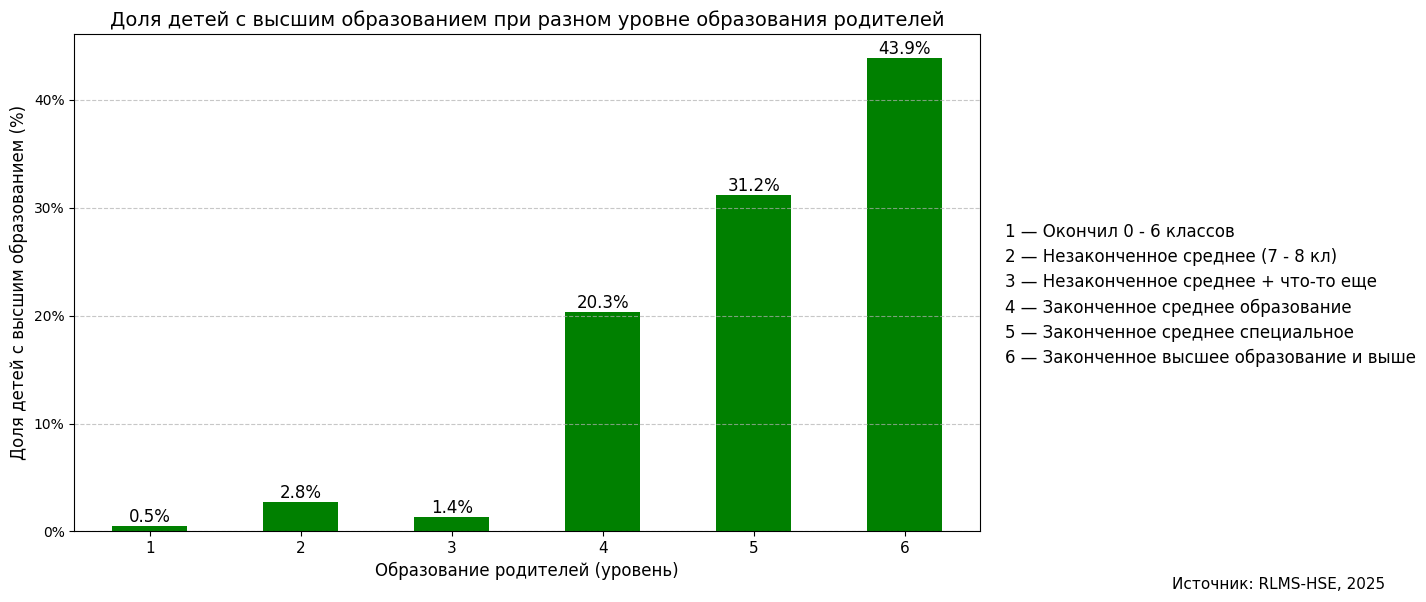

In [17]:
from matplotlib.ticker import FuncFormatter

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))
education_summary.plot(kind='bar', color='green', ax=ax)

# Подписи над столбцами
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.1%}',
            ha='center', va='bottom', fontsize=12)

# Заголовок и подписи осей
ax.set_title('Доля детей с высшим образованием при разном уровне образования родителей', fontsize=14)
ax.set_xlabel('Образование родителей (уровень)', fontsize=12)
ax.set_ylabel('Доля детей с высшим образованием (%)', fontsize=12)
ax.set_xticklabels(education_summary.index, rotation=0, fontsize=11)

# Форматируем ось Y в проценты
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Добавляем расшифровку кодов сбоку
education_legend_text = "\n".join([f"{k} — {v}" for k, v in education_labels.items()])
plt.figtext(1.01, 0.5, education_legend_text, ha='left', va='center', fontsize=12, linespacing=1.5)

# Сетка и источник
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.figtext(1.39, 0.01, 'Источник: RLMS-HSE, 2025', ha='right', fontsize=11)
plt.tight_layout()
plt.show()

**Вывод**: Те индивиды, у которых хотя бы один из родителей имел высшее образование, более склонны к получению высшего образования, чем все остальные индивиды.

Визуализируйте, как образование родителей влияет на структуру образования их детей, при помощи stacked bar графика (где по горизонтальной оси будет образование родителей, а каждый столбец графика будет разбит на части пропорционально доли детей с тем или иным уровнем образования).

Для этого задания лучше использовать переменную «bb_diplom», а не более детализированную «bb_educ».

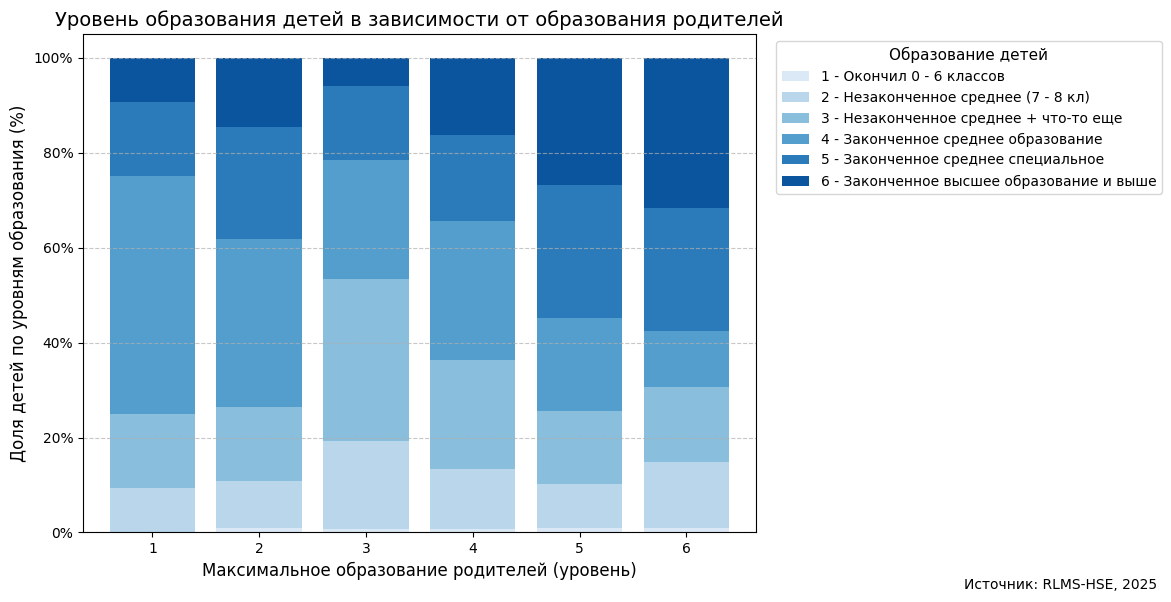

In [18]:
# Кросс-таблица: уровни образования родителей (максимальный) vs уровни образования детей
pivot_table = pd.crosstab(
    df_parents_diplom['max_parent_diplom'],
    df_parents_diplom['bb_diplom'],
    normalize='index'  # нормируем по строкам — получим доли
)

# Сортировка столбцов по коду диплома (если нужно)
pivot_table = pivot_table[sorted(pivot_table.columns)]

# Визуализация stacked bar
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(14, 6))
pivot_table.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=sns.color_palette("Blues", n_colors=pivot_table.shape[1]),
    width=0.8
)

# Настройки оформления
ax.set_title('Уровень образования детей в зависимости от образования родителей', fontsize=14)
ax.set_xlabel('Максимальное образование родителей (уровень)', fontsize=12)
ax.set_ylabel('Доля детей по уровням образования (%)', fontsize=12)

# Подписи оси X
ax.set_xticklabels(
    education_labels.keys(),
    rotation=0,
    fontsize=10
)

# Y-ось в процентах
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.tick_params(axis='y', labelsize=10)


# Добавляем расшифровку код

# Легенда
ax.legend(
    title='Образование детей',
    labels=[f'{int(i)} - ' + education_labels.get(i, str(i)) for i in pivot_table.columns],
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    fontsize=10,
    title_fontsize=11
)
plt.figtext(0.83, 0.01, 'Источник: RLMS-HSE, 2025', ha='right', fontsize=10)

# Сетка и компоновка
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


По графику видно, что при достаточно высоком образовании родителей (уровни 5 - 6), дети более склонны к получению высшего образования

### 4.3 Формулировка и проверка гипотез IV

1. Изучите доступные в RLMS данные и сформулируйте три разные гипотезы о том, какие характеристики родителей могут влиять на те же самые (или другие!) характеристики детей (помимо образования). При формулировке гипотез обязательно приведите ссылки на релевантные, актуальные и авторитетные источники (научные исследования по схожей проблематике на зарубежном статистическом материале).

2. Проверьте ваши гипотезы на данных. Для этого сформулируйте необходимые разрезы данных, рассчитайте статистики, визуализируйте (в виде графиков или таблиц) ваши расчёты. Сделайте вывод о том, как результаты соотносятся со сформулированными гипотезами.

3. Кратко охарактеризуйте результаты вашего исследования в рамках одного абзаца текста.

#### Гипотеза 1. Стрессоустойчивость родителей коррелирует с этим же качеством у их детей.

В исследованиях [1], [2], [3] рассматривается связь между стрессоустойчивостью родителей и их детей, а также влияние генетических и социальных факторов. Авторитетные теории утверждают, что устойчивость к стрессу у родителей способствует созданию более стабильной и поддерживающей среды для детей. В такой среде дети могут развить лучшие навыки саморегуляции, снизить уровень тревожности и адаптироваться к стрессовым ситуациям.

Кроме того, дети могут перенимать стратегии преодоления трудностей от родителей через постоянное взаимодействие и наблюдение. Родители, демонстрирующие высокую стрессоустойчивость, создают модели поведения, которые дети могут адаптировать для собственных нужд. Это особенно актуально для детей с высокой восприимчивостью к стрессу: такие дети часто развивают повышенную стрессоустойчивость как ответ на стабильность и поддержку, исходящие от родителей. В семьях с высокими уровнями стрессоустойчивости родители создают более конструктивные механизмы преодоления трудностей, что способствует улучшению адаптации детей в сложных ситуациях и снижению их тревожности.

**Источники**
1. Li, H., Song, G., Xiao, B. (2024). The Relationship between Parental Stress and Child Conformity: The Mediating Role of Resilience. International Journal of Mental Health Promotion, 26(9), 767–776.

2. Belsky, J., & Pluess, M. (2009).
"Beyond diathesis stress: Differential susceptibility to environmental influences"

3. Masarik, A. S., et al. (2014).
"For better and for worse: Genes and parenting interact to predict future behavior in romantic relationships"


#### Проверка на данных:
В 32 волне опроса есть переменная
bbj445.5 - ответ на вопрос "Вы спокойны в стрессовых ситуациях?"

Для проверки этой гипотезы возьмем только тех индивидов, для которых можно найти информацию хотя бы об одном родителе в 32 волне опроса (2023 год). Также отбросим тех индивидов, у кого нет ответа на вопрос bbj445.5 или у кого нет хотя бы одного родителя, ответившего на этот вопрос.
Для тех, у кого есть данные о стрессоустойчивости обоих родителей, возьмем максимум из их стрессоустойчивостей (то есть минимум из ответов, так как чем меньше цифра в ответе, тем больше стрессоустойчивость, это следует из расшифровки ответа)

Расшифровка ответов:\
1 - Почти всегда\
2 - Чаще всего\
3 - Иногда\
4 - Почти никогда\
88888888 - Респондент не смог ответить на этот вопрос даже после двух попыток

In [19]:
stress_labels = {1 : 'Высокая', 2 : 'Средне-высокая', 3 : 'Средняя', 4 : 'Низкая'}    # Расшифровка ответов
# 88888888 - 'Нет ответа' (впоследствии заменим это значение на fill)

id_ind = set(df_ind['idind'])    # Создаем множество всех id индивидов в 32 волне
df_parents_32 = df_parents[(df_parents['mother'].isin(id_ind)) | (df_parents['father'].isin(id_ind))].copy() # Фильтруем и создаем копию

In [20]:
# Подготовка данных

df_parents_stress = df_parents_32.copy()    # Создаем датафрейм с показателями стресса
df_parents_stress = df_parents_stress.merge(df_ind_32[['idind', 'bbj445.5']], on='idind', how='left')

df_parents_stress = df_parents_stress.merge(df_ind_32[['idind', 'bbj445.5']], left_on='mother', right_on='idind', how='left', suffixes=('','_mother'))
df_parents_stress = df_parents_stress.merge(df_ind_32[['idind', 'bbj445.5']], left_on='father', right_on='idind', how='left', suffixes=('','_father'))

df_parents_stress.drop(columns=['idind_mother', 'idind_father'], inplace=True)
df_parents_stress.fillna(fill, inplace=True)    # Заполняем пропуски
df_parents_stress.replace(88888888, fill, inplace=True)    # Заменяем отсутствие ответа на пропуск
df_parents_stress.rename(columns={'bbj445.5' : 'ind_stress', 'bbj445.5_mother' : 'mother_stress', 'bbj445.5_father' : 'father_stress'}, inplace=True) # Переименовываем колонки

df_parents_stress['parents_stress'] = df_parents_stress[['mother_stress', 'father_stress']].min(axis=1)    # Берем минимальное из двух значений


In [21]:
# Отбросим тех, у кого нет информации о стрессоустойчивости
df_parents_stress = df_parents_stress[(df_parents_stress['ind_stress'] != fill) & (df_parents_stress['parents_stress'] != fill)]

def analyze_parent_child_stress(df):
    res = df[df['ind_stress'] == 1].groupby('parents_stress').size() # Считаем количество детей с высшим образованием по уровням образования родителей
    stress_summary = res / res.sum() # Считаем доли
    return stress_summary

stress_summary = analyze_parent_child_stress(df_parents_stress)

stress_summary

parents_stress
1.0    0.327103
2.0    0.401869
3.0    0.214953
4.0    0.056075
dtype: float64

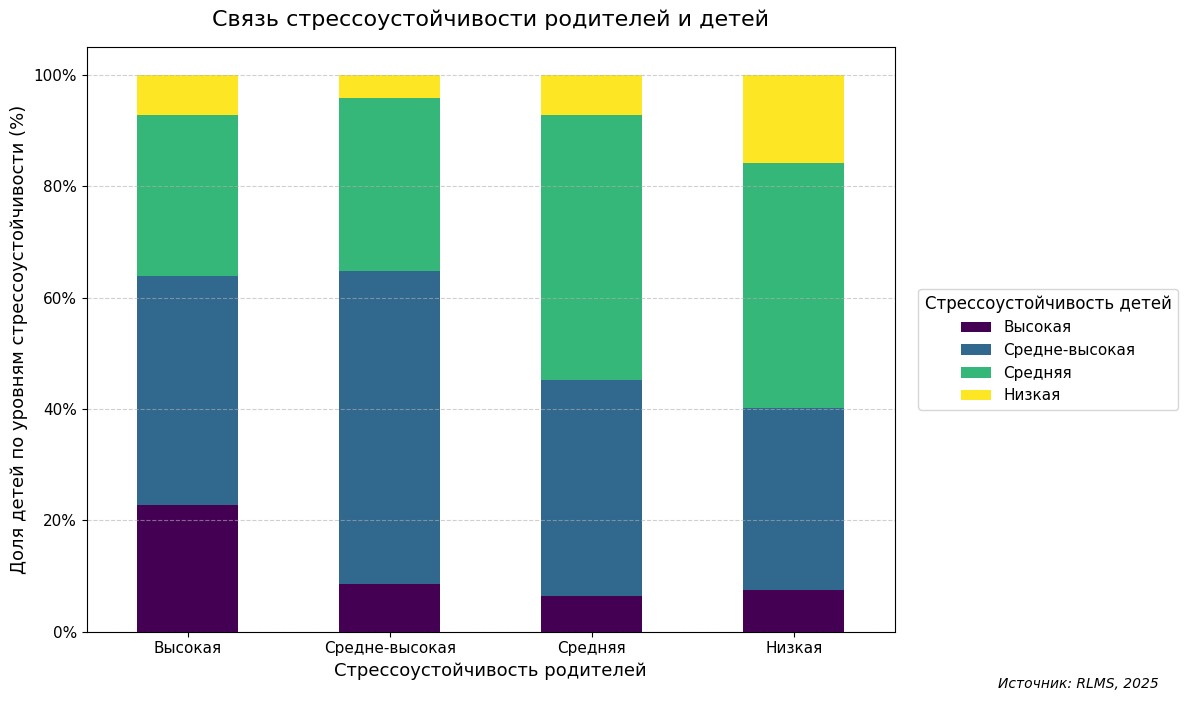

In [22]:
# Сопоставление чисел меткам
df_parents_stress['parents_stress_label'] = df_parents_stress['parents_stress'].map(stress_labels)
df_parents_stress['ind_stress_label'] = df_parents_stress['ind_stress'].map(stress_labels)

# Кросс-таблица и нормализация
crosstab = pd.crosstab(df_parents_stress['parents_stress_label'], df_parents_stress['ind_stress_label'])
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)

# Упорядочим метки
ordered_labels = [stress_labels[i] for i in sorted(stress_labels.keys())]
crosstab_normalized = crosstab_normalized.reindex(index=ordered_labels, columns=ordered_labels)

# Построение графика
fig, ax = plt.subplots(figsize=(12, 7))

crosstab_normalized.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Заголовки
ax.set_title('Связь стрессоустойчивости родителей и детей', fontsize=16, pad=15)
ax.set_xlabel('Стрессоустойчивость родителей', fontsize=13)
ax.set_ylabel('Доля детей по уровням стрессоустойчивости (%)', fontsize=13)

# Подписи осей и легенда
ax.set_xticklabels(crosstab_normalized.index, rotation=0, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.legend(title='Стрессоустойчивость детей', title_fontsize=12, fontsize=11, bbox_to_anchor=(1.02, 0.6), loc='upper left')

# Форматирование Y-оси в проценты
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Сетка и оформление
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Источник
plt.figtext(0.97, 0.01, 'Источник: RLMS, 2025', horizontalalignment='right', fontsize=10, style='italic')

plt.show()

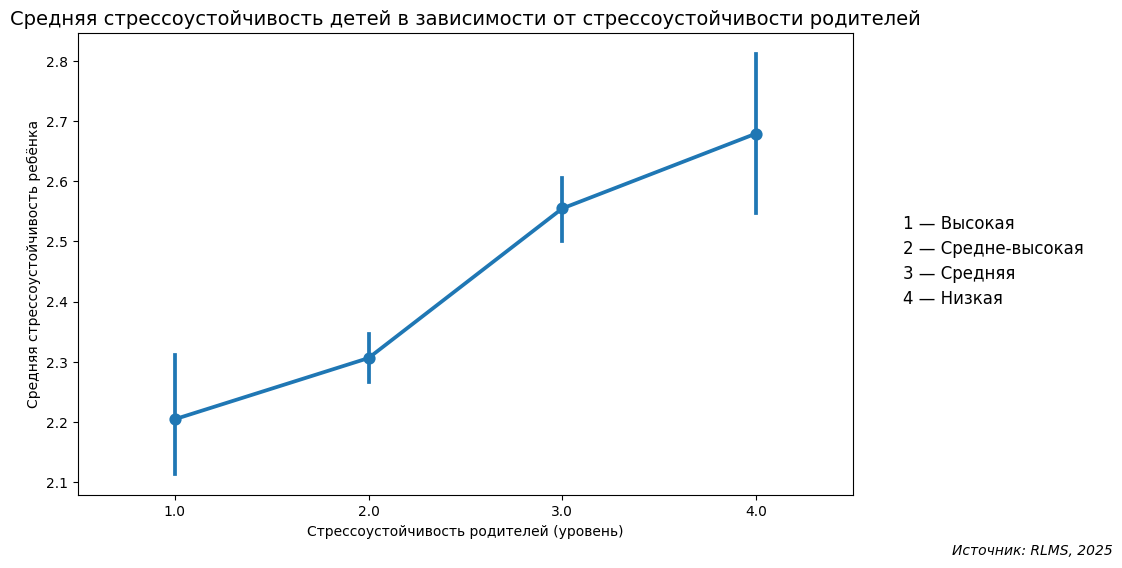

In [23]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='parents_stress', y='ind_stress', data=df_parents_stress)
plt.title("Средняя стрессоустойчивость детей в зависимости от стрессоустойчивости родителей", fontsize=14)
plt.xlabel("Стрессоустойчивость родителей (уровень)")
plt.ylabel("Средняя стрессоустойчивость ребёнка")
education_legend_text = "\n".join([f"{k} — {v}" for k, v in stress_labels.items()])
plt.figtext(0.95, 0.5, education_legend_text, ha='left', va='center', fontsize=12, linespacing=1.5)
plt.figtext(1.16, 0.01, 'Источник: RLMS, 2025', horizontalalignment='right', fontsize=10, style='italic')
plt.show()

In [24]:
from scipy.stats import spearmanr    # берем корреляцию Спирмена

corr_coef, p_value = spearmanr(df_parents_stress['ind_stress'], df_parents_stress['parents_stress'])

print(f"Spearman correlation: {corr_coef:.3f}, p-value: {p_value:.3f}")

Spearman correlation: 0.202, p-value: 0.000


**Вывод**:\
Коэффициент корреляции больше нуля, то есть присутствует положительная связь (хоть и не очень сильная). Также это можно увидеть на графике: чем выше стрессоустойчивость родителей, тем выше средняя стрессоустойчивость детей.\
При этом p-value (уровень значимости) < 0.01, поэтому связь очень значимая и гипотеза верна
Данные подтверждают нашу гипотезу, что стрессоустойчивости родителей и их детей коррелируют.

#### Гипотеза 2. Дети родителей с более высоким социальным статусом (по субъективной лестнице уважения) чаще располагаются выше на собственной лестнице уважения.
Если родители воспринимают себя как уважаемых членов общества, они могут передавать детям более высокий уровень уверенности, ресурсов и социального капитала, что способствует аналогичному самовосприятию у детей.

Исследование [4] подчеркивает, что представление родителей о своем месте в социальной иерархии напрямую влияет на установки и самооценку их детей. Если взрослые воспринимают себя как уважаемых и статусных членов общества, их дети, скорее всего, перенимают эти установки и также ощущают себя полноправными участниками социальной структуры. Это указывает на наличие межпоколенческой передачи субъективного социального статуса.

В работе [5] показано, что высокий социально-экономический статус семьи предсказывает более выраженную мотивацию к успеху у подростков, особенно в ранний период учебы. Авторы также отмечают, что такие дети, как правило, обладают более устойчивой самооценкой и склонны видеть в себе личный ресурс для достижения целей.

Статья [6] акцентирует внимание на том, как субъективная принадлежность к определенному классу влияет на повседневное восприятие мира. Дети, выросшие в семьях, где принято считать себя «выше среднего», чаще демонстрируют уверенность в себе и склонны ориентироваться на амбициозные цели. Социальные сравнения, по мнению автора, становятся фундаментом для формирования ожиданий от себя и других.

Особенно интересные результаты представлены в исследовании [7], где использовался метод сравнения близнецов, выросших в одинаковых условиях. Даже в таких парах различия в субъективной оценке семейного статуса приводили к разному уровню благополучия в молодом возрасте. Подростки, считающие свою семью менее уважаемой, к 25 годам чаще сталкивались с низким уровнем образования, финансовыми трудностями и отсутствием стабильной занятости. Это демонстрирует, насколько значимую роль играет не только объективное положение семьи, но и то, как подростки это положение интерпретируют.

**Источники**

4. Kraus, M. W., Piff, P. K., & Keltner, D. (2011). Social class as culture: The convergence of resources and rank in the social realm. Current Directions in Psychological Science, 20(4), 246–250.

5. Wu, L., Xiao, Y., Chen, Y., & Cheng, G. (2021). Family socioeconomic status, subjective social status, and achievement motivation among Chinese college freshmen: A latent growth modeling approach. Journal of Social and Personal Relationships, 38(7), 2141-2161.

6. Fiske, S. T. (2010). Envy up, scorn down: How comparison divides us. American Psychologist, 65(8), 698–706.

7. Rivenbark, J., Arseneault, L., Caspi, A., Danese, A., Fisher, H. L., Moffitt, T. E., Rasmussen, L. J. H., Russell, M. A., & Odgers, C. L. (2020). Adolescents' perceptions of family social status correlate with health and life chances: A twin difference longitudinal cohort study. Proceedings of the National Academy of Sciences of the United States of America, 117(38)


#### Проверка на данных

В данных по опросам индивидов за 2023 год присутствует переменная bbj63 - ответ на вопрос "Представьте себе лестницу, из 9 ступеней, где на нижней ступени стоят совсем бесправные, а на высшей - те, у кого большая власть. На какой из девяти ступеней находитесь сегодня Вы лично?"

Лестница уважения позволяет нам оценить субъективный социальный статус индивидов.
Будем учитывать только тех индивидов, которые отвечали на данный вопрос в 2023 году и у которых хотя бы один из родителей отвечал на данный вопрос в 2023 году. Если оба родителя отвечали на вопрос, то возьмем максимум из их ответов.

In [25]:
# Подготовка данных

df_parents_status = df_parents.copy()

# Подтянем ответы индивидов и их родителей
df_parents_status = df_parents_status.merge(df_ind_32[['idind', 'bbj63']], on='idind', how='left')
df_parents_status = df_parents_status.merge(df_ind_32[['idind', 'bbj63']], left_on='mother', right_on='idind', how='left', suffixes=('','_mother'))
df_parents_status = df_parents_status.merge(df_ind_32[['idind', 'bbj63']], left_on='father', right_on='idind', how='left', suffixes=('','_father'))

df_parents_status.fillna(fill, inplace=True)

# Временно заменяем пропуски на нули для корректного применения функции max()
df_parents_status.replace(fill, 0, inplace=True)
df_parents_status['parents_status'] = df_parents_status[['bbj63_mother', 'bbj63_father']].max(axis=1)
# Заменяем нули обратно на пропуски
df_parents_status.replace(0, fill, inplace=True)

df_parents_status.rename(columns={'bbj63' : 'ind_status'}, inplace=True)
df_parents_status.drop(columns=['idind_mother', 'bbj63_mother', 'idind_father', 'bbj63_father'], inplace=True)

# Берем только индивидов, по которым есть нужные данные
df_parents_status = df_parents_status[(df_parents_status['ind_status'] != fill) & (df_parents_status['parents_status'] != fill)]

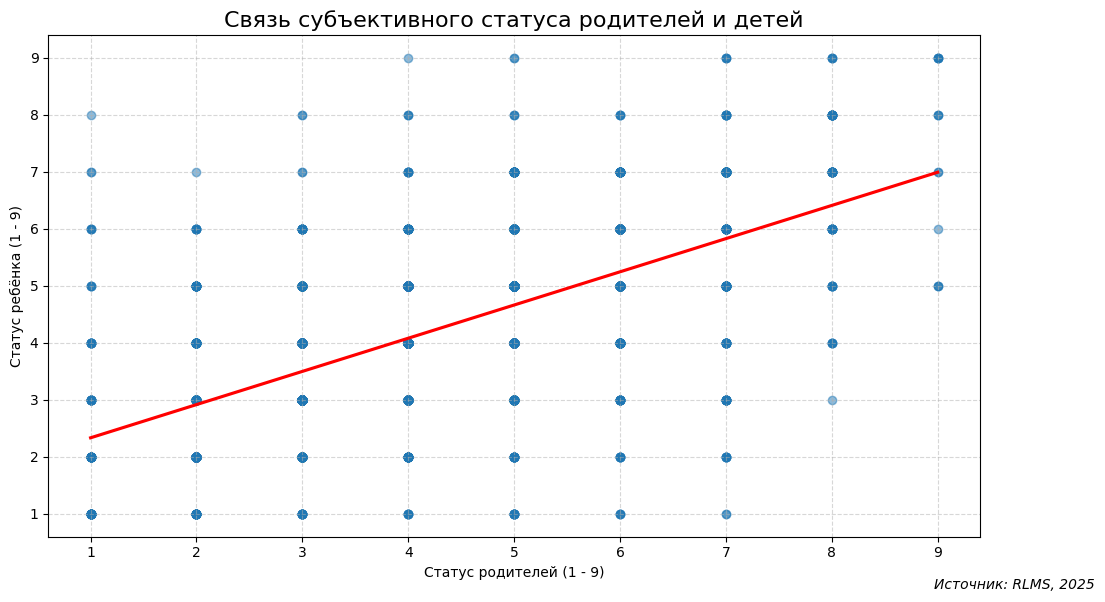

In [26]:
# Визуализация: scatterplot с линейным трендом

plt.figure(figsize=(10, 6))
sns.regplot(x='parents_status', y='ind_status', data=df_parents_status, scatter_kws={'alpha':0.5}, ci=None, line_kws={'color':'red'})
plt.title('Связь субъективного статуса родителей и детей', fontsize=16)
plt.xlabel('Статус родителей (1 - 9)')
plt.ylabel('Статус ребёнка (1 - 9)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.figtext(1.1, 0.01, 'Источник: RLMS, 2025', horizontalalignment='right', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

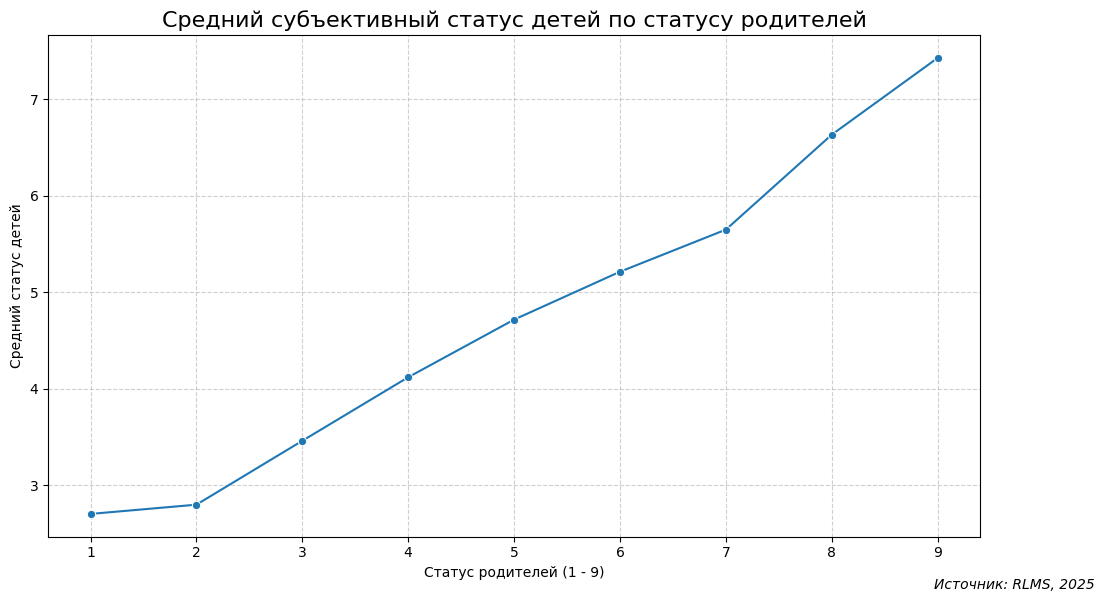

In [27]:
# Визуализация: линейный график

mean_values = df_parents_status.groupby('parents_status')['ind_status'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='parents_status', y='ind_status', data=mean_values, marker='o')
plt.title('Средний субъективный статус детей по статусу родителей', fontsize=16)
plt.xlabel('Статус родителей (1 - 9)')
plt.ylabel('Средний статус детей')
plt.grid(True, linestyle='--', alpha=0.6)
plt.figtext(1.1, 0.01, 'Источник: RLMS, 2025', horizontalalignment='right', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

In [28]:
# Расчёт корреляции Спирмена
corr, p_value = spearmanr(df_parents_status['parents_status'], df_parents_status['ind_status'])

print(f"Коэффициент корреляции Спирмена: {corr:.2f}, p-value: {p_value:.4f}")

Коэффициент корреляции Спирмена: 0.60, p-value: 0.0000


**Вывод**\
Мы получили коэффициент корреляции 0.6, означает наличие довольно большой положительной зависимости между субъективным статусом родителей и их детей. При этом p_value получился меньше 0.001, что говорит о сильной статистической значимости.\
Таким образом, данные подтверждают нашу гипотезу о том, что дети родителей с более высоким субъективным социальным статусом чаще располагаются выше на субъективной лестнице уважения

#### Гипотеза 3. Дети родителей с высоким уровнем социального взаимодействия, как правило, демонстрируют более высокий уровень общительности.
Чем общительнее, дружелюбнее родители, тем проще их детям в коммуникациях.

В ряде исследований подтверждается, что уровень социального взаимодействия родителей влияет на развитие общительности у их детей. В работе [8] показано, что дети родителей с широкими и активными социальными связями — с друзьями, соседями, коллегами — с раннего возраста демонстрируют лучшую адаптацию в коллективе, большую уверенность в общении и более высокий уровень просоциального поведения. Родители в таких семьях чаще демонстрируют положительные коммуникативные модели (эмпатия, сотрудничество, умение разрешать конфликты), которые дети перенимают через наблюдение. Кроме того, насыщенная социальная жизнь родителей создает для детей больше поводов и площадок для взаимодействия со сверстниками, а наличие внешней поддержки у родителей снижает уровень стресса и способствует более мягкому, устойчивому стилю воспитания.

Аналогичный результат дает исследование [9], где прослеживается межпоколенческая передача социальных навыков. Родители, обладающие высокой эмпатией и способностью к конструктивному диалогу, чаще воспитывают детей, которые демонстрируют аналогичные качества во взрослом возрасте. Такие дети реже сталкиваются с межличностными трудностями, лучше справляются с конфликтами и, в целом, проявляют более развитую социальную компетентность. Это подчеркивает роль семейной среды и повседневных взаимодействий в формировании у ребёнка устойчивых моделей общения, сохраняющихся на протяжении жизни.

**Источники**

8. Neitola, M., af Ursin, P., & Pihlaja, P. (2023). Explaining children’s social relationships in early childhood: the role of parental social networks. European Early Childhood Education Research Journal, 32(3), 383–398. 

9. Burke, T. J., Woszidlo, A., & Segrin, C. (2013). The Intergenerational Transmission of Social Skills and Psychosocial Problems among Parents and their Young Adult Children. Journal of Family Communication, 13(2), 77–91. 


#### Проверка на данных
В данных по опросам индивидов за 2023 год присутствует переменная bbj445.20 - ответ на вопрос "Вы открыты и общительны, например, Вы очень легко заводите друзей?"

Данная переменная позволяет нам оценивать общительность индивидов.\
Будем учитывать только тех индивидов, которые отвечали на данный вопрос в 2023 году и у которых хотя бы один из родителей отвечал на данный вопрос в 2023 году. Если оба родителя отвечали на вопрос, то возьмем более общительного родителя, то есть минимум из их ответов (так как чем меньше цифра в ответе, тем более общительный индивид)

In [29]:
# Подготовка данных

df_parents_sociability = df_parents.copy()

# Подтянем ответы индивидов и их родителей
df_parents_sociability = df_parents_sociability.merge(df_ind_32[['idind', 'bbj445.20']], on='idind', how='left')
df_parents_sociability = df_parents_sociability.merge(df_ind_32[['idind', 'bbj445.20']], left_on='mother', right_on='idind', how='left', suffixes=('','_mother'))
df_parents_sociability = df_parents_sociability.merge(df_ind_32[['idind', 'bbj445.20']], left_on='father', right_on='idind', how='left', suffixes=('','_father'))

# Заменяем значение "респондент не смог ответить на этот вопрос даже после двух попыток" значением пропуска
df_parents_sociability.replace(88888888, fill, inplace=True)
df_parents_sociability.fillna(fill, inplace=True)

df_parents_sociability['parents_sociability'] = df_parents_sociability[['bbj445.20_mother', 'bbj445.20_father']].min(axis=1)
df_parents_sociability.replace(88888888, fill, inplace=True)
df_parents_sociability.rename(columns={'bbj445.20' : 'ind_sociability'}, inplace=True)
df_parents_sociability.drop(columns=['idind_mother', 'bbj445.20_mother', 'idind_father', 'bbj445.20_father'], inplace=True)
df_parents_sociability = df_parents_sociability[(df_parents_sociability['ind_sociability'] != fill) & (df_parents_sociability['parents_sociability'] != fill)]

# Расшифровка ответов (уровни общительности)
sociability_labels = {
    1: 'Высокий',
    2: 'Средне-высокий',
    3: 'Средний',
    4: 'Низкий'
}

# Преобразуем числовые значения в текстовые категории
df_parents_sociability['parents_sociability'] = df_parents_sociability['parents_sociability'].map(sociability_labels)
df_parents_sociability['ind_sociability'] = df_parents_sociability['ind_sociability'].map(sociability_labels)

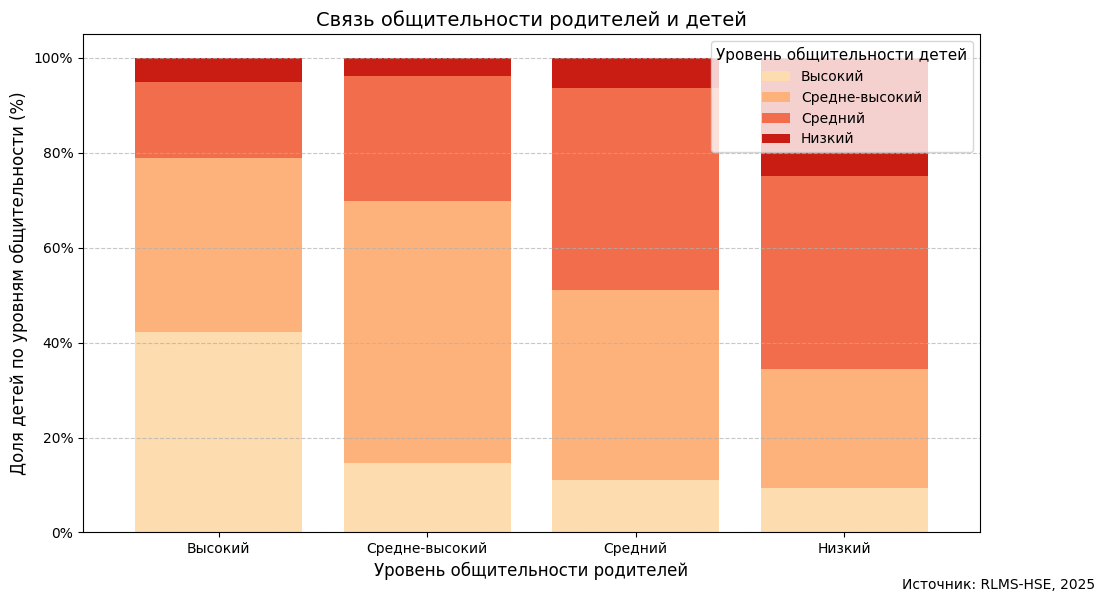

In [30]:
# Создаем кросс-таблицу: строки — родители, столбцы — дети
pivot = pd.crosstab(
    df_parents_sociability['parents_sociability'],
    df_parents_sociability['ind_sociability'],
    normalize='index'
)

# Упорядочим уровни
sociability_order = ['Высокий', 'Средне-высокий', 'Средний', 'Низкий']
pivot = pivot.reindex(index=sociability_order)
pivot = pivot[sociability_order]  # важно: переупорядочиваем столбцы

# Построение графика
ax = pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=sns.color_palette("OrRd", n_colors=len(pivot.columns)),
    width=0.8
)

# Настройка графика
plt.title('Связь общительности родителей и детей', fontsize=14)
ax.set_xlabel('Уровень общительности родителей', fontsize=12)
ax.set_ylabel('Доля детей по уровням общительности (%)', fontsize=12)
ax.set_xticklabels(pivot.index, rotation=0, fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.tick_params(axis='y', labelsize=10)

ax.legend(
    title='Уровень общительности детей',
    loc='upper right',
    fontsize=10,
    title_fontsize=11
)

plt.figtext(1.1, 0.01, 'Источник: RLMS-HSE, 2025', ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
# Применяем тест хи-квадрат
from scipy.stats import chi2_contingency

# Контингентная таблица для хи-квадрат теста
contingency = pd.crosstab(df_parents_sociability['parents_sociability'], df_parents_sociability['ind_sociability'])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Хи-квадрат: {chi2:.2f}, p-value: {p:.4f}")

Хи-квадрат: 370.80, p-value: 0.0000


**Вывод**\
Мы получили p_value < 0.001, что указывает на высокую статистическую значимость связи между наблюдаемыми переменными. Также на графике мы можем увидеть эту связь: чем выше уровень общительности у родителей, тем выше он у детей.\
Таким образом, мы подтвердили нашу гипотезу на данных о том, что размер и качество социальных связей, общительность родителей влияет на общительность их детей.

### Выводы по результатам исследования

Анализ межпоколенческой передачи социальных характеристик по трём направлениям — стрессоустойчивости, субъективному статусу и уровню общительности — показал, что между поколениями существуют устойчивые и значимые связи. Мы обнаружили, что дети родителей с высокой стрессоустойчивостью сами чаще демонстрируют способность справляться со стрессом. Аналогично, субъективный социальный статус родителей связан с тем, как оценивают своё положение их дети. Также в семьях наблюдается повторяемость уровня общительности — дети часто наследуют коммуникативные особенности своих родителей.

Эти результаты важны, потому что социальные качества, передающиеся между поколениями, напрямую влияют на будущее человека. Согласно статье [1], нематериальные характеристики — в том числе статус и личностные ресурсы — играют важную роль в социальной мобильности и в том, насколько у детей будут равные стартовые возможности.

Таким образом, понимание того, как нематериальные ресурсы передаются в семьях, помогает лучше разобраться в причинах неравенства и позволяет создавать более точные меры поддержки. Наши выводы основаны на данных RLMS-HSE и подтверждаются собственным анализом.


**Список используемой литературы:**

1. Li, H., Song, G., Xiao, B. (2024). The Relationship between Parental Stress and Child Conformity: The Mediating Role of Resilience. International Journal of Mental Health Promotion, 26(9), 767–776.

2. Belsky, J., & Pluess, M. (2009).
"Beyond diathesis stress: Differential susceptibility to environmental influences"

3. Masarik, A. S., et al. (2014).
"For better and for worse: Genes and parenting interact to predict future behavior in romantic relationships"

4. Kraus, M. W., Piff, P. K., & Keltner, D. (2011). Social class as culture: The convergence of resources and rank in the social realm. Current Directions in Psychological Science, 20(4), 246–250.

5. Wu, L., Xiao, Y., Chen, Y., & Cheng, G. (2021). Family socioeconomic status, subjective social status, and achievement motivation among Chinese college freshmen: A latent growth modeling approach. Journal of Social and Personal Relationships, 38(7), 2141-2161.

6. Fiske, S. T. (2010). Envy up, scorn down: How comparison divides us. American Psychologist, 65(8), 698–706.

7. Rivenbark, J., Arseneault, L., Caspi, A., Danese, A., Fisher, H. L., Moffitt, T. E., Rasmussen, L. J. H., Russell, M. A., & Odgers, C. L. (2020). Adolescents' perceptions of family social status correlate with health and life chances: A twin difference longitudinal cohort study. Proceedings of the National Academy of Sciences of the United States of America, 117(38)

8. Neitola, M., af Ursin, P., & Pihlaja, P. (2023). Explaining children’s social relationships in early childhood: the role of parental social networks. European Early Childhood Education Research Journal, 32(3), 383–398. 

9. Burke, T. J., Woszidlo, A., & Segrin, C. (2013). The Intergenerational Transmission of Social Skills and Psychosocial Problems among Parents and their Young Adult Children. Journal of Family Communication, 13(2), 77–91. 

10. Hout, M. (2015). A Summary of What We Know About Social Mobility. The ANNALS of the American Academy of Political and Social Science, 657(1), 27–36.
